# Non-Point FoV Sensor Model

In [ ]:
%matplotlib widget  

import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import *

from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

np.random.seed(0)
tf.random.set_seed(0)

## Setup helper functions for plotting the 3D sensor placements

In [2]:
'''
Plotting utils to map inducing points to sensing FoV
'''
def get_corners(X, size):
    corners = np.zeros((X.shape[0]//(size**2), 5, 3))
    X = X.reshape(-1, size**2, 2)
    corners[:, 0, :2] = X.min(axis=1)
    corners[:, 1, :2] = np.array([X[:, :, 0].min(axis=1), X[:, :, 1].max(axis=1)]).T
    corners[:, 2, :2] = X.max(axis=1)
    corners[:, 3, :2] = np.array([X[:, :, 0].max(axis=1), X[:, :, 1].min(axis=1)]).T
    # center
    corners[:, 4, :2] = X.mean(axis=1)
    return corners

def align_idx(a, b):
    dists = pairwise_distances(a, Y=b, metric='euclidean')
    _, ind = linear_sum_assignment(dists)
    return ind

'''
Get GP predictions with the solution placements as support points
'''
def get_reconstruction(X_test, y_test, Xu, data_variance, rbf):
    # Get test data indices corresponding to the solution placements
    dists = pairwise_distances(X_test, Y=Xu, metric='euclidean')
    row_ind, _ = linear_sum_assignment(dists)
    Xu_X = X_test[row_ind].copy()
    Xu_y = y_test[row_ind].copy()

    # Get GP predictions with the solution placements as support points
    gpr = gpflow.models.GPR((Xu_X, Xu_y),
                            noise_variance=data_variance,
                            kernel=rbf)
    y_pred, y_var = gpr.predict_f(X_test)
    y_pred = y_pred.numpy().reshape(-1, 1)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    return y_pred, y_var, Xu_X, rmse

## Get the data and initial SGP hyperparameters

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.5661980547582317   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [2.73598 3.1363 ]    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0130333531276

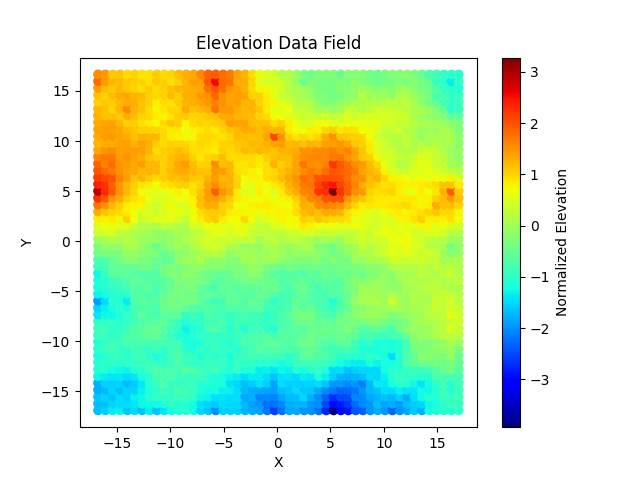

In [3]:
# Get the synthetic elevation data
dataset = 'synthetic'
X_train, y_train, X_test, y_test, candidates, X, y = get_dataset(dataset)
train_dim = np.sqrt(X_train.shape[0]).astype(int)
test_dim = np.sqrt(X_test.shape[0]).astype(int)

# Train the GP and get the model parameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], 
                                             optimizer='scipy')

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="jet")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Elevation Data Field')
plt.colorbar(label='Normalized Elevation')
plt.show()

## Initialize the inducing points and non-point FoV transform

In [4]:
num_robots = 1
num_placements = 9
num_side = 5 # Use 5x5 point FoV approximation

# Get initial inducing points
Xu_init = get_inducing_pts(X_train, num_placements)
# Initalize height dimension at 2.0 for all points
Xu_init = np.concatenate((Xu_init, np.ones((Xu_init.shape[0], 1))*2.0), axis=1)
Xu_init[:, :2] = run_tsp(Xu_init[:, :2])[0][0]

# Initialize the non-point FoV transform
transform = SquareHeightTransform(num_side=num_side)

## Plot the initial solution

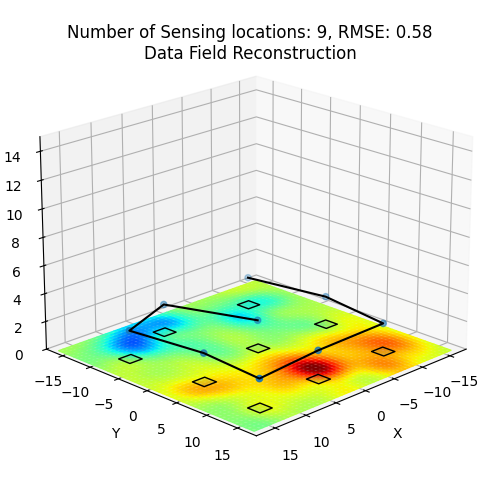

In [5]:
# Get reconstructed environment state
sgp_sol_sp = Xu_init.copy()
sgp_sol, sgp_var, sgp_sol_X, rmse = get_reconstruction(X_test, y_test, 
                                                       transform.expand(sgp_sol_sp).numpy(),
                                                       noise_variance, 
                                                       kernel)

# Get the corners of FoV
vertices = get_corners(transform.expand(sgp_sol_sp).numpy(), num_side)
idx = align_idx(vertices[:, 4, :2], sgp_sol_sp[:, :2])
vertices[:, 4] = sgp_sol_sp[idx]

# Setup 3D plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

# Plot the reconstructed environment state
norm = colors.Normalize(y_train.min(), y_train.max())
cset = ax.plot_surface(X_test[:, 0].reshape(test_dim, test_dim),
                       X_test[:, 1].reshape(test_dim, test_dim),
                       np.atleast_2d(-0.1),
                       facecolors=plt.cm.jet(norm(sgp_sol.reshape(test_dim, test_dim))),
                       shade=False,
                       alpha=0.8,
                       zorder=0)

# Plot the solution path and FoV
ax.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], sgp_sol_sp[:, 2])
ax.plot(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], sgp_sol_sp[:, 2], 'k-')
vertices[:, :, 2] = 0
for i in range(vertices.shape[0]):
    verts = []
    verts.append([vertices[i, 0], vertices[i, 1], 
                vertices[i, 2], vertices[i, 3]])
    ax.add_collection3d(Poly3DCollection(verts, linewidths=1.0, 
                                        edgecolors='k', alpha=0.1))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-18, 18)
ax.set_ylim(-18, 18)
ax.set_zlim(0, 15)

ax.view_init(elev=20., azim=45)
ax.set_title(f'Number of Sensing locations: {num_placements}, RMSE: {rmse:.2f}\nData Field Reconstruction', y=0.97)

plt.tight_layout()
plt.show()

## Optimize the sensor placements

In [6]:
# Optimize the placements
sgpr, _ = continuous_sgp(num_placements,
                         X_train, 
                         noise_variance,
                         kernel,
                         transform=transform,
                         Xu_init=Xu_init)
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()

## Plot the optimized solution

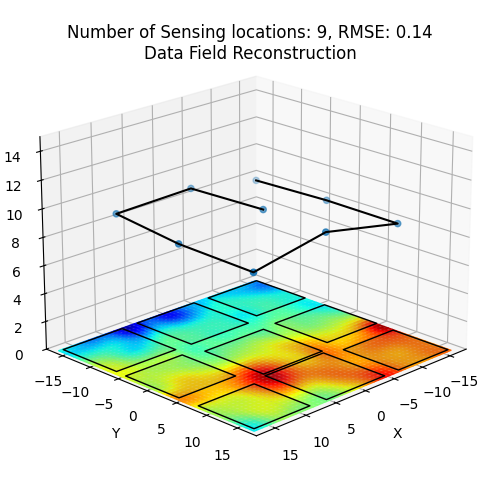

In [7]:
# Get reconstructed environment state
sgp_sol, sgp_var, sgp_sol_X, rmse = get_reconstruction(X_test, y_test, 
                                                       transform.expand(sgp_sol_sp).numpy(),
                                                       noise_variance, 
                                                       kernel)

# Get the corners of FoV
vertices = get_corners(sgpr.transform.expand(sgp_sol_sp).numpy(), num_side)
idx = align_idx(vertices[:, 4, :2], sgp_sol_sp[:, :2])
vertices[:, 4] = sgp_sol_sp[idx]

# Setup 3D plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

# Plot the reconstructed environment state
norm = colors.Normalize(y_train.min(), y_train.max())
cset = ax.plot_surface(X_test[:, 0].reshape(test_dim, test_dim),
                       X_test[:, 1].reshape(test_dim, test_dim),
                       np.atleast_2d(-0.1),
                       facecolors=plt.cm.jet(norm(sgp_sol.reshape(test_dim, test_dim))),
                       shade=False,
                       alpha=0.8,
                       zorder=0)

# Plot the solution path and FoV
ax.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], sgp_sol_sp[:, 2])
ax.plot(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], sgp_sol_sp[:, 2], 'k-')
vertices[:, :, 2] = 0
for i in range(vertices.shape[0]):
    verts = []
    verts.append([vertices[i, 0], vertices[i, 1], 
                vertices[i, 2], vertices[i, 3]])
    ax.add_collection3d(Poly3DCollection(verts, linewidths=1.0, 
                                        edgecolors='k', alpha=0.1))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-18, 18)
ax.set_ylim(-18, 18)
ax.set_zlim(0, 15)

ax.view_init(elev=20., azim=45)
ax.set_title(f'Number of Sensing locations: {num_placements}, RMSE: {rmse:.2f}\nData Field Reconstruction', y=0.97)

plt.tight_layout()
plt.show()